# Facebook Prophet

### Обучение модели Facebook

install packages

In [3]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
import plotly as py

%matplotlib inline
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Загрузка данных

In [28]:
ts= pd.read_csv('dataset1_with_outliers_data.csv')
ts.info

<bound method DataFrame.info of               ds         y
0     2008-01-30  5.976351
1     2008-01-16  6.049733
2     2008-01-17  6.011267
3     2008-01-14  5.953243
4     2008-01-15  5.910797
...          ...       ...
2858  2015-12-11  7.834788
2859  2015-12-12  7.360104
2860  2015-12-13  7.479864
2861  2015-12-18  7.765145
2862  2015-12-19  7.220374

[2863 rows x 2 columns]>

In [29]:
ts.head()

,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797


In [30]:
ts.head(950)

,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797
...,...,...
945,2010-09-28,8.000000
946,2010-09-29,8.000000
947,2010-09-02,8.000000
948,2010-09-03,8.000000


Видем, что есть интервал с пропущенными значениями. Перенесем их в отдельную переменную.

In [31]:
ts.index = pd.to_datetime(ts['ds'])

ts = pd.read_csv('dataset1_with_outliers_data.csv')
ts.index = pd.to_datetime(ts['ds'])
ts.sort_index(inplace=True)

ts_test = ts[datetime(2015,1,1):]

ts_full = ts[:datetime(2015,1,1)]
ts_no_outs = ts_full[datetime(2012, 1,1):]

Посмотрим на весь график :

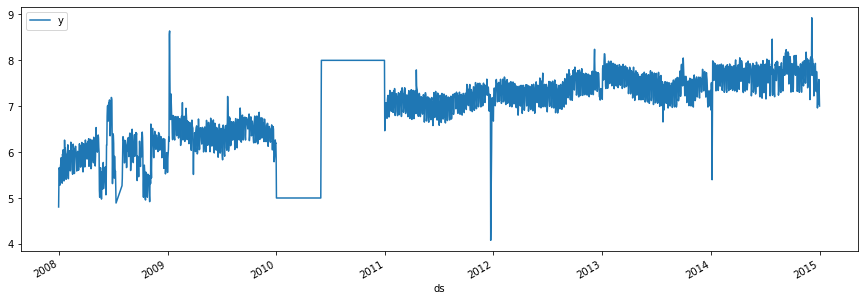

In [32]:
ts_full.plot(figsize=(15,5))

И data_wihout_outs

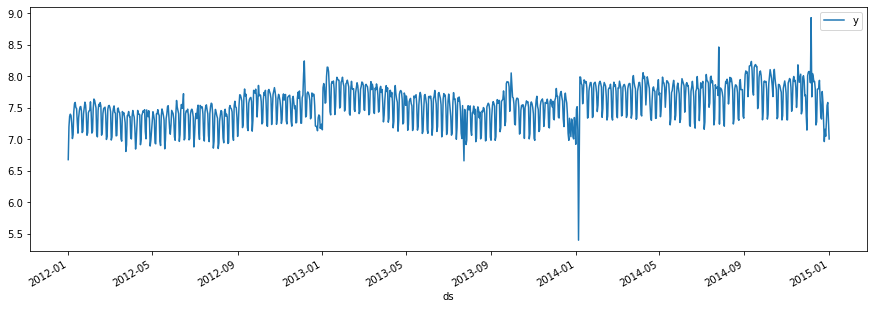

In [33]:
ts_no_outs.plot(figsize=(15,5))

### Проверим ряд на стационарность :

Проверьте ряд на стационарность (например, с помощью критерия Дики-Фуллера). Попробуйте привести его к стационарному виду (с помощью преобразования Бокса-Кокса, дифференцирования etc.)
После получения стационарного ряда напишите функцию прямой transform и обратной inv_transform трансформации временного ряда (т.е. исходный ряд -> стационарный ряд и стационарный ряд -> исходный ряд).

In [34]:
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_no_outs['y'])[1])

 Критерий Дики-Фуллера: p=0.074175


In [35]:
def transform(df):
    plt.figure(figsize=(15,10))
    sm.tsa.seasonal_decompose(df['y'], freq = 30).plot()
    print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])

### Попробуем обноружить выбросы :

С помощью экспоненциального сглаживания найдите выбросы в данных (и попробуйте их сгладить). Для этого подберите оптимальные значения параметров alpha, beta и std_window. Функция для детекции аномалий и сглаживания приведена ниже. Обратите внимание, мы работаем лишь с ts_train, тестовый датасет ts_test "находится в будущем" и нам недоступен.

In [36]:
def exponential_smoothing_anomaly_filter(series, alpha, beta=2.5, std_window=10):



    result = [series[0]] # first value is same as series
    sx = series.rolling(std_window).std()
    anomalies_index = []
    anomalies_values = []
#     print(len(series), len(sx))
    for n in range(1, len(series)):
        if n > std_window:
            if abs(series[n] - result[n-1]) > sx[n]*beta:
                result.append(result[n-1])
                anomalies_index.append(series.index[n])
                anomalies_values.append(series[n])
                continue
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(index=series.index, data=result), pd.Series(index=anomalies_index, data=anomalies_values)

In [37]:
ts_no_outs['ty'], ts_no_outs['ay'] = exponential_smoothing_anomaly_filter(ts_no_outs['y'], 0.35, 1.5, 29)
dk = sm.tsa.stattools.adfuller(ts_no_outs['ty'])[1]
dk

0.01918734883565836

 Критерий Дики-Фуллера: p=0.019187


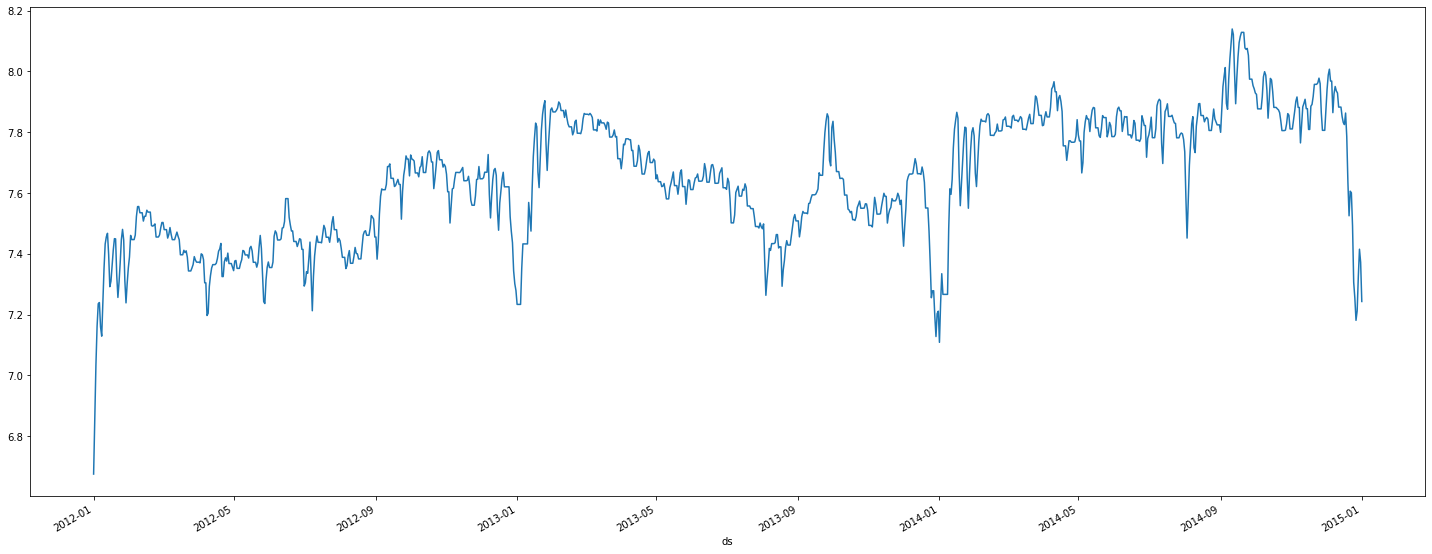

In [38]:
plt.figure(figsize=(25,10))
ts_no_outs['ty'].plot()
print(" Критерий Дики-Фуллера: p=%f" % dk)

### Построем прогнозы с помощью библиотеки Facebook Prophet

In [39]:
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
fmodel = Prophet()


fmodel.fit(ts_no_outs)
future = fmodel.make_future_dataframe(periods=365)

forecast = fmodel.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


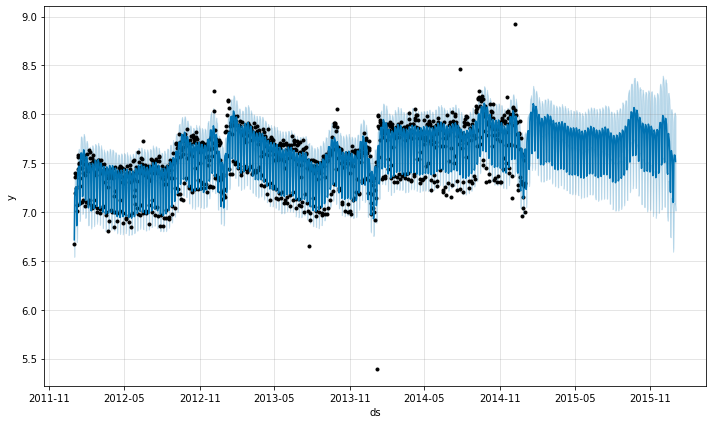

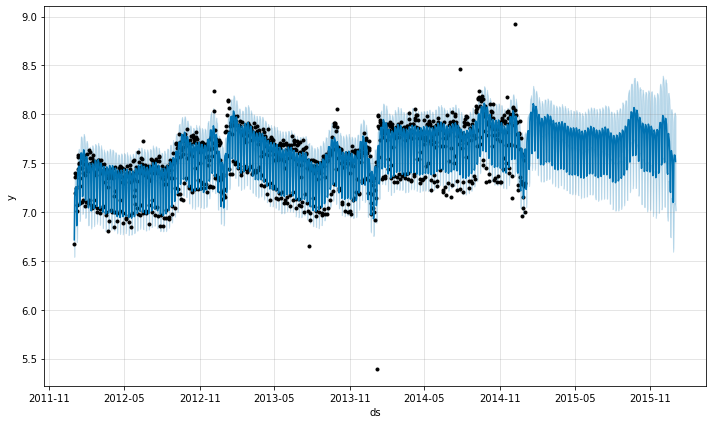

In [40]:
fmodel.plot(forecast)

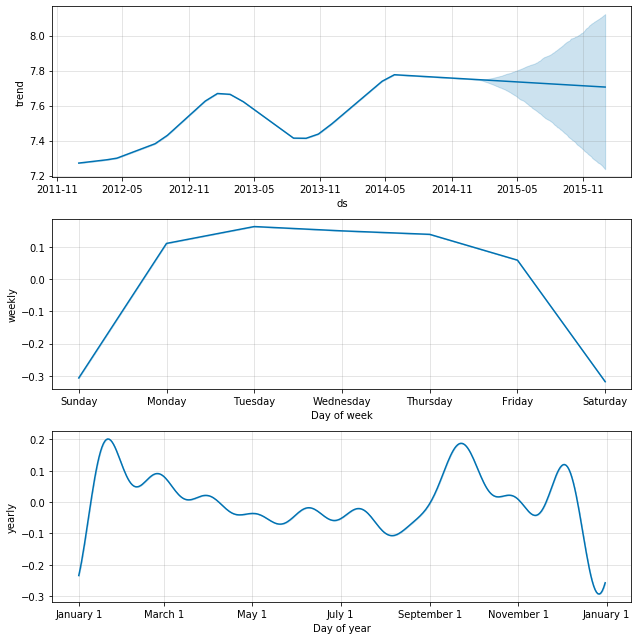

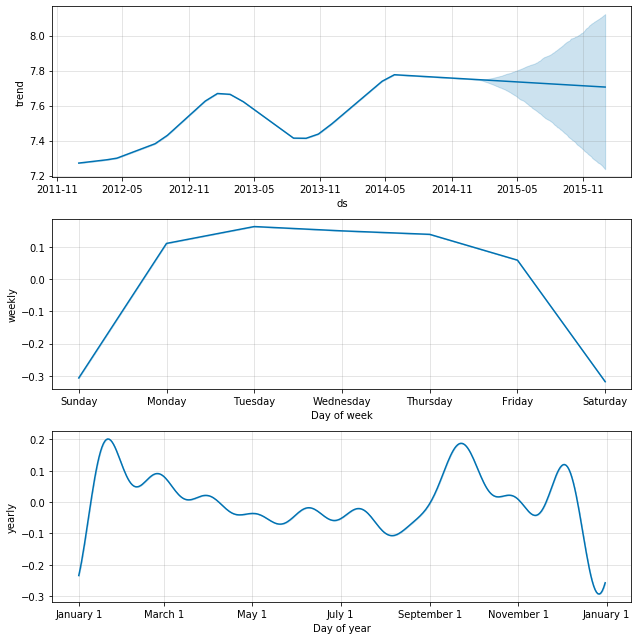

In [41]:
fmodel.plot_components(forecast)

# ts_full

In [59]:
fmodel1 = Prophet()

fmodel1.fit(ts_full)
future1 = fmodel1.make_future_dataframe(periods=365)

forecast1 = fmodel1.predict(future1)

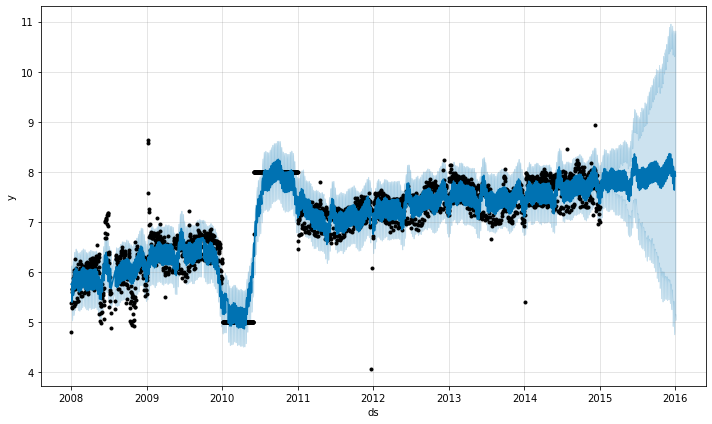

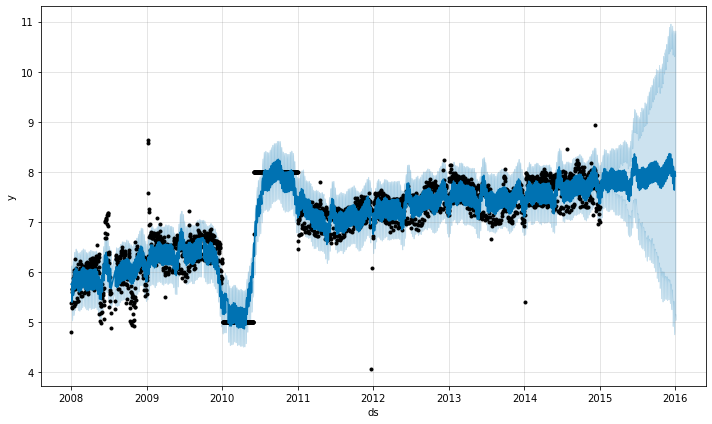

In [60]:
fmodel1.plot(forecast1)

Оценим качество прогноза с помощью MSE, MAE и $r^2$-score.

In [58]:
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [45]:
cmp_df  = make_comparison_dataframe(ts_no_outs, forecast)

In [46]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 9.155094299426086
MAE 0.6412204369243755


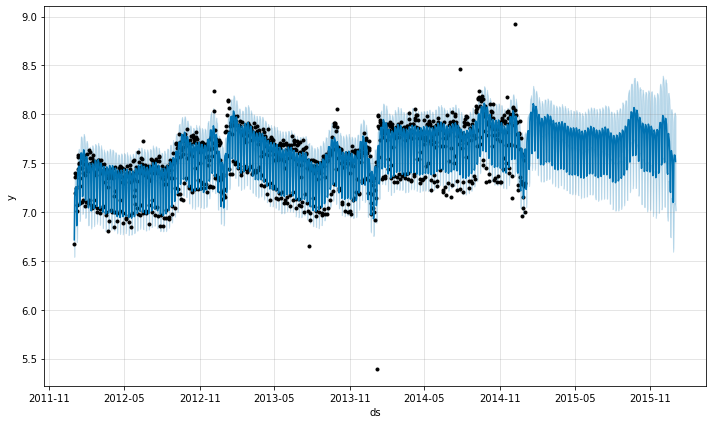

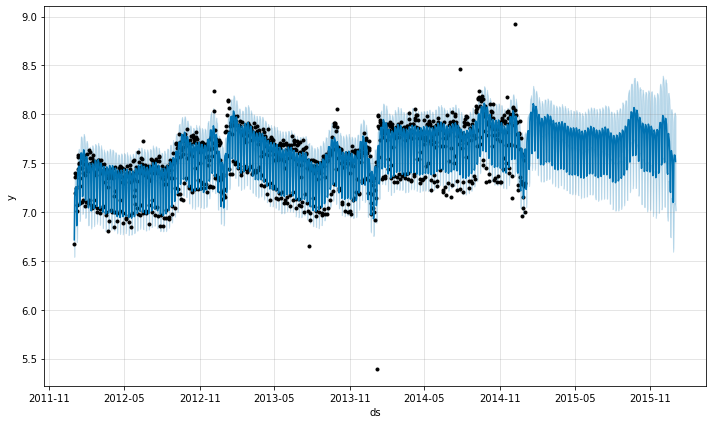

In [47]:
fmodel.plot(forecast)

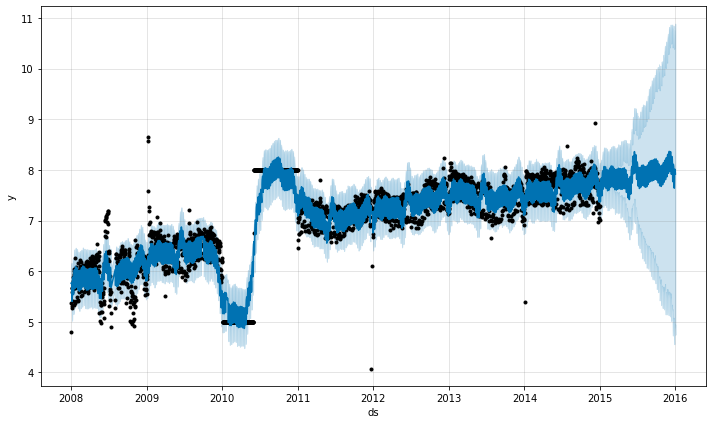

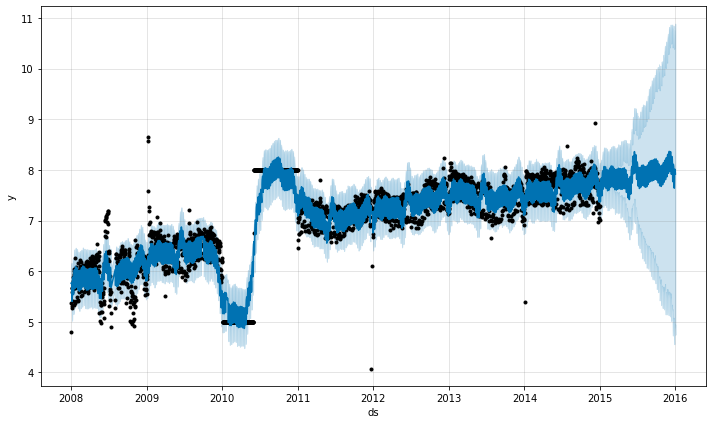

In [57]:
fmodel1.plot(forecast1)

### Автоматическая работа с пропущенными значениями (25%)

На самом деле, библиотека Facebook Prophet умеет работать с пропущенными значениями. Создадим копию ts_copy ряда ts_full и заменим в ней значения с 2010-01-01 по 2011-01-01 на None.

In [49]:
ts_copy = ts_full.copy()
ts_copy['y'][datetime(2010,1,1):datetime(2011,1,1)] = None
ts_copy[datetime(2010,1,1):datetime(2011,1,1)]

,ds,y
ds,,
2010-01-01,2010-01-01,NaN
2010-01-02,2010-01-02,NaN
2010-01-03,2010-01-03,NaN
2010-01-04,2010-01-04,NaN
2010-01-05,2010-01-05,NaN
...,...,...
2010-12-28,2010-12-28,NaN
2010-12-29,2010-12-29,NaN
2010-12-30,2010-12-30,NaN


In [61]:
fmodel2 = Prophet()

fmodel2.fit(ts_copy)
future2 = fmodel2.make_future_dataframe(periods=365)

forecast2 = fmodel2.predict(future2)

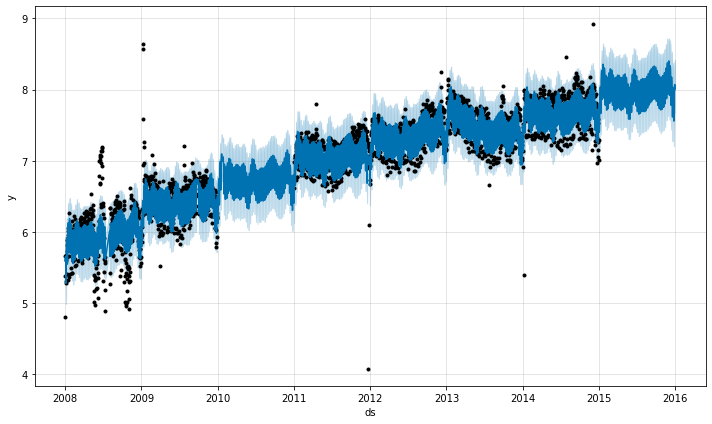

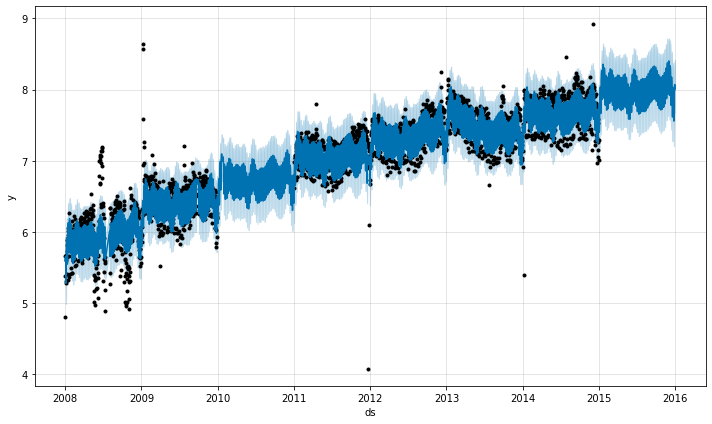

In [56]:
fmodel2.plot(forecast2)

In [52]:
cmp_df  = make_comparison_dataframe(ts_copy, forecast2)

In [53]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 11.158847749364778
MAE 0.7815628103217698


MSE было 9.171853243470927, а стало 11.15781712755453, алгоритм хуже предсказывает.
Добавим информации о выходных днях(суббота и воскресенье)

In [69]:
saturday  = pd.DataFrame({
  'holiday': 'saturday',
  'ds': ts.loc[ts.index.weekday == 5].ds
})


sunday  = pd.DataFrame({
  'holiday': 'sunday',
  'ds': ts.loc[ts.index.weekday == 6].ds
})

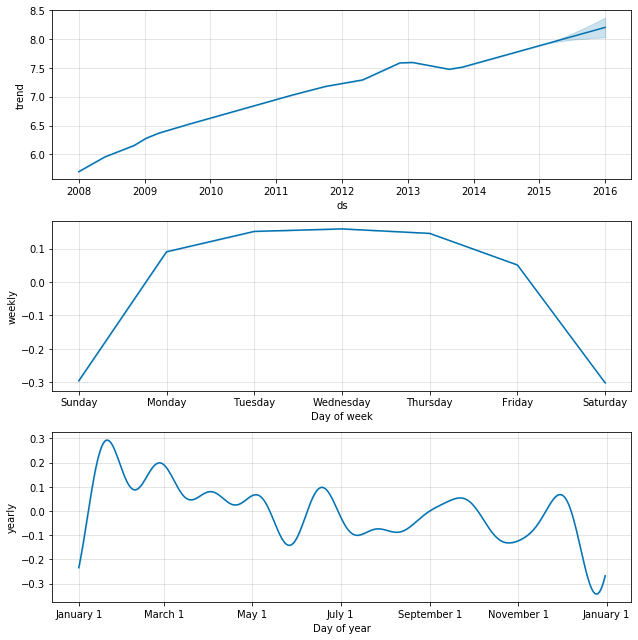

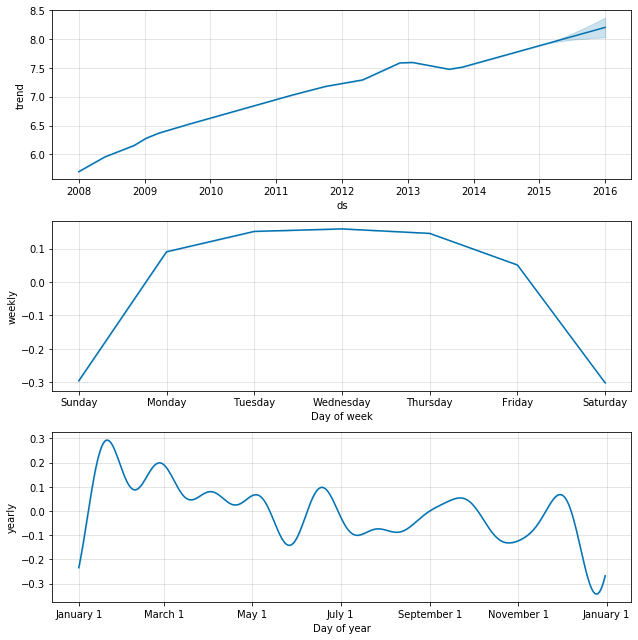

In [70]:
fmodel2.plot_components(forecast2)

Построем прогноз на год вперед c учетом выходных дней на основании ts_copy

In [71]:
ts_copy = ts_full.copy()
ts_copy['y'][datetime(2011,1,1):datetime(2012,1,1)] = None
ts_copy[datetime(2011,1,1):datetime(2012,1,1)]

,ds,y
ds,,
2011-01-01,2011-01-01,NaN
2011-01-02,2011-01-02,NaN
2011-01-03,2011-01-03,NaN
2011-01-04,2011-01-04,NaN
2011-01-05,2011-01-05,NaN
...,...,...
2011-12-28,2011-12-28,NaN
2011-12-29,2011-12-29,NaN
2011-12-30,2011-12-30,NaN


In [72]:
fmodel4 = Prophet()
fmodel4.fit(ts_copy)
future4 = fmodel2.make_future_dataframe(periods=365)
forecast4 = fmodel4.predict(future4)

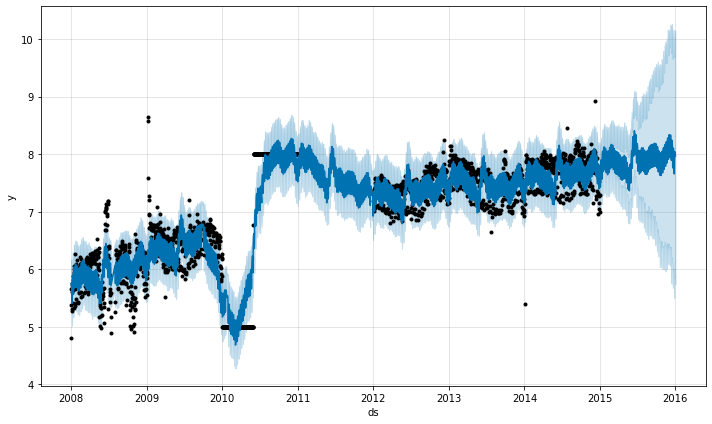

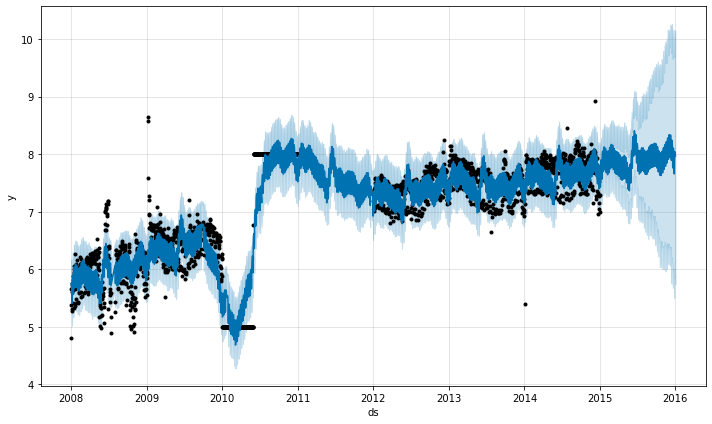

In [73]:
fmodel4.plot(forecast4)

Оценим качество прогноза с помощью MSE, MAE и $r^2$-score еще раз.

In [74]:
import numpy as np
cmp_df  = make_comparison_dataframe(ts_copy, forecast4)
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 11.227507141252778
MAE 0.7863716963720364


MSE было 11.15781712755453, а стало 11.227507141252778, cредняя ошибка возросла при пропущенных данных, следовательно алгоритм стал хуже предсказывать.